# Approche hybride avec LightFM

## Données

### Chargement du dataframe global

In [1]:
import pandas as pd

df_clicks = pd.read_parquet("./data/df_final.parquet")
print("✅ Dataset rechargé avec succès.")

✅ Dataset rechargé avec succès.


In [2]:
df_clicks.head()

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,...,31,32,33,34,35,36,37,38,39,40
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,...,-0.321484,0.910162,-0.413011,0.680835,-0.418409,-0.526443,0.305625,-0.307805,-0.606366,-0.650556
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,...,-1.001013,0.797471,-0.492230,-0.305857,-1.307835,0.354010,0.696917,-0.486316,0.017210,-1.563045
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,...,-0.269690,0.873445,0.194144,0.056367,-0.431036,-0.020383,-0.376942,0.814494,0.709722,-1.030146
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,...,0.144034,-2.457183,-1.500929,-1.807169,-0.208940,-0.671638,-0.407914,2.561696,-1.379031,-1.877568
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,...,-1.163678,-0.230112,-2.132536,-0.729996,0.581913,-0.559910,-0.354824,-0.914158,-0.064399,-0.354175


## Matrice utilisateur-item

| Situation | Stratégie sur la matrice user-item | Raison |
|----------|-------------------------------------|--------|
| **Collaborative pur** (pas de features) | 🔥 Maximiser l'intensité : `alpha` élevé, `weighting='log'`, **pas de normalisation** | Cela amplifie les différences de préférence et donne du signal fort à LightFM |
| **Hybride (avec user/item features)** | ⚖️ Normalisation cohérente des valeurs dans `[0, 1]` sur **toutes les matrices** (y compris interactions) | Cela évite que les features soient écrasées ou négligées par un déséquilibre d’échelle | 

<br>
C'est le principe de <b>l'équilibrage des signaux dans les systèmes hybrides de recommandation</b>. Si on normalise seulement les features mais la matrice user-item reste avec des valeurs hautes les features seront ignées par le le modèle. Si on normalise tout il faut éviter d'écraser la variance <br>

🛠️ Bonnes pratiques à appliquer<br>
| Élément | Bonne échelle |
|--------|----------------|
| `user_features` | `[0, 1]` (via MinMax ou OneHot) |
| `item_features` | `[0, 1]` (MinMax + embeddings déjà compressés) |
| `interaction_matrix` | `[0, 1]` uniquement si features aussi présentes (sinon garder amplitudes fortes) |

In [3]:
from scipy.sparse import coo_matrix
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def build_user_item_matrix_for_lightfm(df_clicks, weighting="log", alpha=40.0, normalize=False):
    """
    Construit une matrice CSR (utilisateurs × articles) pour LightFM avec pondération et normalisation optionnelles.

    Paramètres :
    - df_clicks : DataFrame avec 'user_id' et 'click_article_id'
    - weighting : 'log' ou 'linear'
    - alpha : pondération log
    - normalize : False, 'minmax', 'standard', 'log', 'user_minmax', 'user_standard', ou fonction custom

    Retourne :
    - user_item_matrix : matrice CSR
    - user_mapping : dict {user_id → index}
    - item_mapping : dict {click_article_id → index}
    """
    # Agrégation des clics
    df_user_item = (
        df_clicks.groupby(['user_id', 'click_article_id'])
        .size()
        .reset_index(name='click_strength')
    )

    # Mappings
    print("🔄 Construction des dictionnaires d’indexation...")
    user_ids = df_user_item['user_id'].unique()
    item_ids = df_user_item['click_article_id'].unique()

    user_mapping = {uid: idx for idx, uid in enumerate(tqdm(user_ids, desc="🔢 Mapping users"))}
    item_mapping = {iid: idx for idx, iid in enumerate(tqdm(item_ids, desc="🧾 Mapping articles"))}

    df_user_item['user_idx'] = df_user_item['user_id'].map(user_mapping)
    df_user_item['item_idx'] = df_user_item['click_article_id'].map(item_mapping)

    # Pondération
    if weighting == "log":
        df_user_item['weight'] = 1.0 + alpha * np.log1p(df_user_item['click_strength'])
        print(f"🧮 Pondération logarithmique avec alpha={alpha}")
    elif weighting == "linear":
        df_user_item['weight'] = df_user_item['click_strength'].astype(float)
        print("🧮 Pondération linéaire")
    else:
        raise ValueError("Le paramètre 'weighting' doit être 'log' ou 'linear'.")

    # Normalisation
    if normalize:
        print(f"📏 Normalisation des poids : {normalize}")
        if normalize == 'minmax':
            scaler = MinMaxScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'standard':
            scaler = StandardScaler()
            df_user_item['weight'] = scaler.fit_transform(df_user_item[['weight']])
        elif normalize == 'log':
            df_user_item['weight'] = np.log1p(df_user_item['weight'])
        elif normalize == 'user_minmax':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif normalize == 'user_standard':
            df_user_item['weight'] = df_user_item.groupby('user_idx')['weight'].transform(
                lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
            )
        elif callable(normalize):
            df_user_item['weight'] = normalize(df_user_item['weight'].values)
        else:
            raise ValueError("Le paramètre 'normalize' doit être False, 'minmax', 'standard', 'log', "
                             "'user_minmax', 'user_standard' ou une fonction.")

    # Matrice sparse
    print("📐 Construction de la matrice sparse (CSR)...")
    user_item_matrix = coo_matrix(
        (df_user_item['weight'],
         (df_user_item['user_idx'], df_user_item['item_idx']))
    ).tocsr()

    print(f"✅ Matrice prête : {user_item_matrix.shape} (utilisateurs × articles)")
    return user_item_matrix, user_mapping, item_mapping


In [4]:
# Création de la matrice et des mappages d'index
# # Pas de normalisation (collaborative pur)
# build_user_item_matrix_for_lightfm(df_clicks, normalize=False)
# # Hybride avec normalisation MinMax
# build_user_item_matrix_for_lightfm(df_clicks, normalize='minmax')
# # Hybride avec log compression
# build_user_item_matrix_for_lightfm(df_clicks, normalize='log')

user_item_matrix, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(df_clicks, normalize=False)

🔄 Construction des dictionnaires d’indexation...


🧾 Mapping articles: 100%|██████████| 46033/46033 [00:00<00:00, 4783973.74it/s]


🧮 Pondération logarithmique avec alpha=40.0
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (322897, 46033) (utilisateurs × articles)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>Note :</strong> Contrairement à Implicit on ne filtre pas les utilisateurs ayant moins de 3 interactions afin de ne pas occulter la situation correspond à beaucoup de cas: utilisateur peu actif. Les métriques seront sans doute moins bonnes qu'avec un filtrage
</div>

## Split LOO

In [5]:
import numpy as np
from scipy.sparse import csr_matrix, lil_matrix

def leave_one_out_split(interactions):
    """
    Réalise un split Leave-One-Out sur une matrice utilisateurs × articles.
    
    Paramètres :
    - interactions : csr_matrix (n_users x n_items)

    Retourne :
    - train : csr_matrix (interactions moins 1 par utilisateur)
    - test : csr_matrix (1 interaction par utilisateur)
    """
    assert isinstance(interactions, csr_matrix), "La matrice d'entrée doit être au format CSR."

    print("🔄 Split Leave-One-Out en cours...")

    interactions = interactions.tolil()  # Accès rapide ligne par ligne
    n_users, n_items = interactions.shape

    train = lil_matrix(interactions.shape, dtype=np.float32)
    test = lil_matrix(interactions.shape, dtype=np.float32)

    rng = np.random.default_rng(seed=42)  # Pour reproductibilité

    for user_id in range(n_users):
        user_interactions = interactions.rows[user_id]
        user_data = interactions.data[user_id]

        if len(user_interactions) >= 2:
            idx = rng.integers(0, len(user_interactions))

            test_item = user_interactions[idx]
            test_value = user_data[idx]

            # Ajouter au test
            test[user_id, test_item] = test_value

            # Ajouter le reste au train
            for i, item in enumerate(user_interactions):
                if i != idx:
                    train[user_id, item] = user_data[i]
        else:
            for i, item in enumerate(user_interactions):
                train[user_id, item] = user_data[i]

    print(f"✅ Split terminé :\n - Train shape : {train.shape}\n - Test shape : {test.shape}")
    return train.tocsr(), test.tocsr()


In [6]:
# Jeux de train et test
train_matrix, test_matrix = leave_one_out_split(user_item_matrix)

🔄 Split Leave-One-Out en cours...
✅ Split terminé :
 - Train shape : (322897, 46033)
 - Test shape : (322897, 46033)


<div style="padding: 10px; border-radius: 5px; background-color: #e7f3fe; color: #31708f; border-left: 6px solid #2196F3;">
ℹ️ <strong>✨ Fonctionnement :</strong> tolil() ➔ convertit temporairement en LIL (list of lists). C'est une structure de matrice creuse qui stocke pour chaque ligne une liste de colonnes non-nulles, une autre list associée qui contient les valeurs de ces colonnes. Donc par ligne on garde: un tableau des indices de colonnes non nulles, un tableau des valeurs correspondantes. Format adapté pour construire, CSR est meilleur pour les calculs (matmul) et la mise en oeuvre du modèle
</div>

## Métriques

### Métriques de recommantion

👉 NDCG@k (Normalized Discounted Cumulative Gain) doit être calculé à la main car LightFM ne le donne pas directement.

In [7]:
from tqdm.notebook import tqdm
import numpy as np
from joblib import Parallel, delayed

def ndcg_at_k(model, test_interactions, train_interactions=None, 
              user_features=None, item_features=None, 
              k=5, num_threads=8):
    """
    Calcule le NDCG@k utilisateur par utilisateur (vectorisé + parallélisé).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_ndcg(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return None

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1
        )).copy() # rend l'array modifiable

        # Masquer les items vus pendant le training
        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        top_k_items = np.argpartition(-scores, k)[:k]
        top_k_items = top_k_items[np.argsort(-scores[top_k_items])]  # tri final

        relevances = np.isin(top_k_items, true_items).astype(int)
        dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
        idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))

        return dcg / idcg if idcg > 0 else 0.0

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_ndcg)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul NDCG@k (parallèle)")
    )

    results = [r for r in results if r is not None]  # supprimer les utilisateurs sans clics
    return np.mean(results) if results else 0.0


### Erreurs RMSE et MAE

📚 Note: LightFM est principalement conçu pour optimiser du ranking (ordre des items) et travailler sur des interactions implicites (clic, vue, achat = 1 ou pas = 0).<br>
RMSE (Root Mean Squared Error) et MAE (Mean Absolute Error) sont normalement utilisés sur :<br>
- des valeurs continues (ex : prédiction d'une note sur 5).
- des modèles de prédiction de score explicite (comme SVD dans Surprise).
  
<br>
👉 Or LightFM peut quand même prédire un score implicite (predict(user, item)) continu. Ce sont des scores relatifs, pas des probabilités calibrées. <br>
👉 Donc on peut comparer ces scores aux clics réels (1 s'il a cliqué, 0 sinon). On a bien une proximité entre le score prédit et le clic réel.<br>
<b>Métriques données pour information, elles ne constituent pas un critère pour LightFM </b>

In [8]:
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from joblib import Parallel, delayed

def compute_rmse_mae(model, test_interactions, train_interactions=None,
                     user_features=None, item_features=None,
                     num_threads=8):
    """
    Calcule RMSE et MAE pour un modèle LightFM (multithreadé et sécurisé).
    """
    n_users, n_items = test_interactions.shape
    test_csr = test_interactions.tocsr()
    train_csr = train_interactions.tocsr() if train_interactions is not None else None

    def compute_user_predictions(user_id):
        true_items = test_csr[user_id].indices
        if len(true_items) == 0:
            return [], []

        scores = np.array(model.predict(
            user_id,
            np.arange(n_items),
            user_features=user_features,
            item_features=item_features,
            num_threads=1  # sécurisé pour joblib threading
        )).copy()  # évite le buffer read-only

        if train_csr is not None:
            train_items = train_csr[user_id].indices
            scores[train_items] = -np.inf

        y_t = [1] * len(true_items)
        y_p = [scores[item] for item in true_items]

        return y_t, y_p

    results = Parallel(n_jobs=num_threads, backend="threading")(
        delayed(compute_user_predictions)(user_id)
        for user_id in tqdm(range(n_users), total=n_users, desc="Calcul RMSE/MAE (parallèle)")
    )

    # Fusion des résultats
    y_true, y_pred = [], []
    for y_t, y_p in results:
        y_true.extend(y_t)
        y_pred.extend(y_p)

    if not y_true:
        raise ValueError("Aucune interaction à évaluer.")

    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)

    return rmse, mae


## Entrainement (baseline: matrice user-item)

In [9]:
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from itertools import product
from tqdm.notebook import tqdm

def grid_search_lightfm(train_matrix, test_matrix,
                        user_features=None, item_features=None,
                        k=5, num_threads=4, max_epochs=30,
                        eval_metric="precision",
                        eval_every=5, patience=3):
    """
    Grid search avec early stopping LightFM (hybride-compatible).

    Nouveaux paramètres :
    - eval_every : fréquence d’évaluation (en epochs)
    - patience : nombre d’évaluations sans amélioration avant arrêt
    - max_epochs : nombre d’epochs max
    """
    from lightfm import LightFM
    from lightfm.evaluation import precision_at_k, recall_at_k
    from itertools import product
    from joblib import Parallel, delayed
    import numpy as np

    # Import ndcg_at_k personnalisé si nécessaire
    def ndcg_at_k(model, test_interactions, train_interactions=None, 
                  user_features=None, item_features=None, 
                  k=5, num_threads=8):
        n_users, n_items = test_interactions.shape
        test_csr = test_interactions.tocsr()
        train_csr = train_interactions.tocsr() if train_interactions is not None else None

        def compute_ndcg(user_id):
            true_items = test_csr[user_id].indices
            if len(true_items) == 0:
                return None
            scores = model.predict(
                user_id,
                np.arange(n_items),
                user_features=user_features,
                item_features=item_features,
                num_threads=1
            ).copy()
            if train_csr is not None:
                train_items = train_csr[user_id].indices
                scores[train_items] = -np.inf
            top_k_items = np.argpartition(-scores, k)[:k]
            top_k_items = top_k_items[np.argsort(-scores[top_k_items])]
            relevances = np.isin(top_k_items, true_items).astype(int)
            dcg = np.sum(relevances / np.log2(np.arange(2, k + 2)))
            idcg = np.sum(1.0 / np.log2(np.arange(2, min(len(true_items), k) + 2)))
            return dcg / idcg if idcg > 0 else 0.0

        results = Parallel(n_jobs=num_threads, backend="threading")(
            delayed(compute_ndcg)(user_id)
            for user_id in range(n_users)
        )
        results = [r for r in results if r is not None]
        return np.mean(results) if results else 0.0

    # Grille de recherche
    param_grid = {
        'loss': ['warp', 'bpr'],
        'no_components': [32, 64],
        'learning_rate': [0.01, 0.05, 0.1]
    }

    best_score = 0.0
    best_model = None
    best_params = None

    all_combinations = list(product(
        param_grid['loss'],
        param_grid['no_components'],
        param_grid['learning_rate']
    ))

    print(f"🔍 Recherche sur {len(all_combinations)} combinaisons...")

    for loss, no_components, learning_rate in all_combinations:
        print(f"\n🚀 Entraînement modèle : loss={loss}, components={no_components}, lr={learning_rate}")
        model = LightFM(
            loss=loss,
            no_components=no_components,
            learning_rate=learning_rate,
            random_state=42
        )

        best_local_score = -np.inf
        no_improve_count = 0

        for epoch in range(1, max_epochs + 1):
            model.fit_partial(
                train_matrix,
                user_features=user_features,
                item_features=item_features,
                epochs=1,
                num_threads=num_threads
            )

            if epoch % eval_every == 0:
                # Évaluer
                if eval_metric == "precision":
                    score = precision_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        k=k,
                        num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "recall":
                    score = recall_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        k=k,
                        num_threads=num_threads,
                        user_features=user_features,
                        item_features=item_features
                    ).mean()
                elif eval_metric == "ndcg":
                    score = ndcg_at_k(
                        model,
                        test_matrix,
                        train_interactions=train_matrix,
                        user_features=user_features,
                        item_features=item_features,
                        k=k,
                        num_threads=num_threads
                    )
                else:
                    raise ValueError("Metric invalide")

                print(f"📉 Epoch {epoch} — {eval_metric}@{k} = {score:.4f}")

                if score > best_local_score:
                    best_local_score = score
                    best_model = model
                    best_params = {
                        'loss': loss,
                        'no_components': no_components,
                        'learning_rate': learning_rate,
                        'epoch': epoch
                    }
                    no_improve_count = 0
                else:
                    no_improve_count += 1
                    if no_improve_count >= patience:
                        print(f"🛑 Early stopping à l’epoch {epoch} (aucune amélioration depuis {patience} évaluations)")
                        break

    print("\n✅ Grid search terminé !")
    print(f"🏆 Meilleur modèle : {best_params} avec {eval_metric}@{k} = {best_local_score:.4f}")
    return best_model, best_params, best_local_score


In [10]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix,
    test_matrix,
    user_features=None,
    item_features=None,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

🔍 Recherche sur 12 combinaisons...

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.0370
📉 Epoch 10 — ndcg@5 = 0.0376
📉 Epoch 15 — ndcg@5 = 0.0392
📉 Epoch 20 — ndcg@5 = 0.0401
📉 Epoch 25 — ndcg@5 = 0.0415
📉 Epoch 30 — ndcg@5 = 0.0424

🚀 Entraînement modèle : loss=warp, components=32, lr=0.05
📉 Epoch 5 — ndcg@5 = 0.0506
📉 Epoch 10 — ndcg@5 = 0.0605
📉 Epoch 15 — ndcg@5 = 0.0676
📉 Epoch 20 — ndcg@5 = 0.0732
📉 Epoch 25 — ndcg@5 = 0.0781
📉 Epoch 30 — ndcg@5 = 0.0822

🚀 Entraînement modèle : loss=warp, components=32, lr=0.1
📉 Epoch 5 — ndcg@5 = 0.0418
📉 Epoch 10 — ndcg@5 = 0.0501
📉 Epoch 15 — ndcg@5 = 0.0559
📉 Epoch 20 — ndcg@5 = 0.0612
📉 Epoch 25 — ndcg@5 = 0.0653
📉 Epoch 30 — ndcg@5 = 0.0686

🚀 Entraînement modèle : loss=warp, components=64, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.0382
📉 Epoch 10 — ndcg@5 = 0.0390
📉 Epoch 15 — ndcg@5 = 0.0408
📉 Epoch 20 — ndcg@5 = 0.0433
📉 Epoch 25 — ndcg@5 = 0.0449
📉 Epoch 30 — ndcg@5 = 0.0467

🚀 Entraînement modèle : loss=warp, co

In [11]:
# Provisoire (pour ne pas avoir à refaire la mise au point)
best_params = {'loss': 'bpr', 'no_components': 32, 'learning_rate': 0.05}

### Ré-entrainement du meilleur modèle

In [12]:
import os
import pandas as pd
from lightfm import LightFM
from lightfm.evaluation import precision_at_k, recall_at_k
from tqdm.notebook import tqdm

#### 🎯 Entrainement avec les paramètres optimaux

In [13]:
def train_lightfm_model(train_matrix, best_params, user_features=None, item_features=None, epochs=50, num_threads=8):
    model = LightFM(
        loss=best_params['loss'],
        no_components=best_params['no_components'],
        learning_rate=best_params['learning_rate'],
        random_state=42
    )
    for epoch in tqdm(range(epochs), desc="Entraînement LightFM"):
        model.fit_partial(
            train_matrix,
            user_features=user_features,
            item_features=item_features,
            epochs=1,
            num_threads=num_threads
        )
    return model


#### 🎯 Evaluation

In [14]:
import numpy as np
import os
import pandas as pd
from scipy.sparse import csr_matrix
from lightfm.evaluation import precision_at_k, recall_at_k

def evaluate_lightfm_model(model, train_matrix, test_matrix,
                           user_features=None, item_features=None,
                           k=5, num_threads=8,
                           experiment_name="user-item",
                           results_file="results/experiments_lightfm.csv"):
    """
    Évalue un modèle LightFM sur l'ensemble des utilisateurs,
    avec ou sans user/item features. Enregistre les résultats dans un fichier CSV.
    """

    # Matrices d'interactions
    test_subset = test_matrix
    train_subset = train_matrix
    user_features_subset = user_features
    item_features_subset = item_features

    # 🎯 Top-K métriques intégrées
    hit = precision_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    recall = recall_at_k(model, test_subset, train_interactions=train_subset,
                         user_features=user_features_subset,
                         item_features=item_features_subset,
                         k=k, num_threads=num_threads).mean()

    # 📈 NDCG custom
    print("Shape passée à ndcg_at_k:", test_subset.shape)
    ndcg = ndcg_at_k(model, test_subset, train_interactions=train_subset,
                     user_features=user_features_subset,
                     item_features=item_features_subset,
                     k=k, num_threads=num_threads)

    # 📉 RMSE / MAE custom
    rmse, mae = compute_rmse_mae(model, test_subset, train_interactions=train_subset,
                                 user_features=user_features_subset,
                                 item_features=item_features_subset,
                                 num_threads=num_threads)

    # 📋 Résultats
    new_result = {
        'Experiment': experiment_name,
        'Hit@5': hit,
        'Recall@5': recall,
        'NDCG@5': ndcg,
        'RMSE': rmse,
        'MAE': mae
    }

    # 💾 Sauvegarde CSV
    os.makedirs(os.path.dirname(results_file), exist_ok=True)
    if os.path.exists(results_file):
        results_df = pd.read_csv(results_file)
        results_df = pd.concat([results_df, pd.DataFrame([new_result])], ignore_index=True)
    else:
        results_df = pd.DataFrame([new_result])
    results_df.to_csv(results_file, index=False)
    print(f"📄 Résultats mis à jour dans {results_file}")

    return new_result


#### 🎯 Résultat avec matrice utilisateur-item

In [15]:
model = train_lightfm_model(train_matrix, best_params, epochs=50)

Entraînement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
results = evaluate_lightfm_model(model, train_matrix, test_matrix,
                                 user_features=None, item_features=None)
print(results)

Shape passée à ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

📄 Résultats mis à jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item', 'Hit@5': 0.036471065, 'Recall@5': 0.1823553640944326, 'NDCG@5': 0.12933830583505998, 'RMSE': 2.4708568812487504, 'MAE': 1.9329606758841589}


✅ Résumé du setup : <br>
- ⚙️ Modèle : LightFM (avec ou sans features)
- 📊 Métriques :
    - precision_at_k, recall_at_k (LightFM natif)
    - ndcg_at_k, rmse, mae (custom, full Numpy + Joblib, optimisé)
- 🔁 Évaluation complète sur tout le dataset
- ⚡ Temps total d’évaluation : ≈ 10 minutes
- 💾 Résultats loggés proprement dans un fichier CSV

## Recalcul de la matrice d'interactions pour l'hybride

In [17]:
user_item_matrix_hybrid, user_mapping, item_mapping = build_user_item_matrix_for_lightfm(
    df_clicks, weighting="log", alpha=40.0, normalize="user_minmax"
)
train_matrix_hybrid, test_matrix_hybrid = leave_one_out_split(user_item_matrix_hybrid)


🔄 Construction des dictionnaires d’indexation...


🔢 Mapping users:   0%|          | 0/322897 [00:00<?, ?it/s]

🧾 Mapping articles:   0%|          | 0/46033 [00:00<?, ?it/s]

🧮 Pondération logarithmique avec alpha=40.0
📏 Normalisation des poids : user_minmax
📐 Construction de la matrice sparse (CSR)...
✅ Matrice prête : (322897, 46033) (utilisateurs × articles)
🔄 Split Leave-One-Out en cours...
✅ Split terminé :
 - Train shape : (322897, 46033)
 - Test shape : (322897, 46033)


In [18]:
model_hybrid = train_lightfm_model(train_matrix_hybrid, best_params, epochs=50)

Entraînement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
results = evaluate_lightfm_model(model_hybrid, train_matrix_hybrid, test_matrix_hybrid,
                                 experiment_name='user-minmax_item',
                                 user_features=None, item_features=None)
print(results)

Shape passée à ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

📄 Résultats mis à jour dans results/experiments_lightfm.csv
{'Experiment': 'user-minmax_item', 'Hit@5': 0.00837156, 'Recall@5': 0.041857798165137614, 'NDCG@5': 0.031408007649022615, 'RMSE': 2.0178207146021774, 'MAE': 1.5538137379165575}


## Calcul de la matrice de features utilisateur - features engineering
On calcule feature par feature en adaptant la normalisation

#### 🚀 1 : Nombre de sessions par utilisateur

In [20]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_sessions(df_clicks):
    """
    Extrait et normalise le nombre de sessions par utilisateur (lissage log1p + MinMax).
    
    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_sessions_scaled']
    """
    sessions_per_user = df_clicks.groupby('user_id')['session_id'].nunique().reset_index()
    sessions_per_user.columns = ['user_id', 'num_sessions']
    
    # Log transform pour lisser
    sessions_per_user['num_sessions_log'] = np.log1p(sessions_per_user['num_sessions'])

    # MinMax scaling
    scaler = MinMaxScaler()
    sessions_per_user['num_sessions_scaled'] = scaler.fit_transform(
        sessions_per_user[['num_sessions_log']]
    )

    return sessions_per_user[['user_id', 'num_sessions_scaled']]


In [21]:
sessions_per_user = extract_number_of_sessions(df_clicks)
print(sessions_per_user.head())

   user_id  num_sessions_scaled
0        0             0.197290
1        1             0.269737
2        2             0.087302
3        3             0.269737
4        4             0.149244


#### 🚀 2 : Nombre total de clics par utilisateur

In [22]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_clicks(df_clicks):
    """
    Extrait et normalise le nombre total de clics par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_clicks_scaled']
    """
    clicks_per_user = df_clicks.groupby('user_id').size().reset_index(name='num_clicks')

    # Log transform
    clicks_per_user['num_clicks_log'] = np.log1p(clicks_per_user['num_clicks'])

    # MinMax scaling
    scaler = MinMaxScaler()
    clicks_per_user['num_clicks_scaled'] = scaler.fit_transform(
        clicks_per_user[['num_clicks_log']]
    )

    return clicks_per_user[['user_id', 'num_clicks_scaled']]


In [23]:
clicks_per_user = extract_number_of_clicks(df_clicks)
print(clicks_per_user.head())

   user_id  num_clicks_scaled
0        0           0.182536
1        1           0.243635
2        2           0.084875
3        3           0.297704
4        4           0.162967


#### 🚀 3 : Nombre d'articles distincts cliqués par utilisateur

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_distinct_articles(df_clicks):
    """
    Extrait et normalise le nombre d'articles distincts cliqués par utilisateur (log1p + MinMax).

    Retourne :
    - DataFrame avec colonnes ['user_id', 'num_distinct_articles_scaled']
    """
    distinct_articles_per_user = df_clicks.groupby('user_id')['click_article_id'].nunique().reset_index()
    distinct_articles_per_user.columns = ['user_id', 'num_distinct_articles']

    # Log transform
    distinct_articles_per_user['num_distinct_articles_log'] = np.log1p(distinct_articles_per_user['num_distinct_articles'])

    # MinMax scaling
    scaler = MinMaxScaler()
    distinct_articles_per_user['num_distinct_articles_scaled'] = scaler.fit_transform(
        distinct_articles_per_user[['num_distinct_articles_log']]
    )

    return distinct_articles_per_user[['user_id', 'num_distinct_articles_scaled']]


In [25]:
distinct_articles_per_user = extract_number_of_distinct_articles(df_clicks)
print(distinct_articles_per_user.head())

   user_id  num_distinct_articles_scaled
0        0                      0.187573
1        1                      0.250357
2        2                      0.087217
3        3                      0.305919
4        4                      0.167463


#### 🚀 4 : Heure favorite de connexion par utilisateur - discrétisée

In [26]:
def extract_favorite_hour(df_clicks):
    """
    Extrait l'heure favorite de connexion basée sur session_start pour chaque utilisateur.
    """
    # Convertir session_start en heure
    df_clicks['session_start_hour'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.hour

    # Trouver l'heure favorite (la plus fréquente) pour chaque utilisateur
    favorite_hour_per_user = (
        df_clicks.groupby('user_id')['session_start_hour']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_hour_per_user.columns = ['user_id', 'favorite_hour']

    return favorite_hour_per_user


In [27]:
favorite_hour_per_user = extract_favorite_hour(df_clicks)
print(favorite_hour_per_user.head())

   user_id  favorite_hour
0        0              1
1        1             15
2        2              2
3        3              2
4        4             21


In [28]:
def discretize_favorite_hour_6_periods(favorite_hour_df):
    """
    Discrétise l'heure favorite en 6 classes :
    Nuit profonde, Très tôt, Matin, Début après-midi, Fin après-midi, Soirée.
    """
    def map_hour_to_period(hour):
        if 0 <= hour <= 3:
            return 'Nuit_profonde'
        elif 4 <= hour <= 7:
            return 'Très_tôt'
        elif 8 <= hour <= 11:
            return 'Matin'
        elif 12 <= hour <= 15:
            return 'Début_après_midi'
        elif 16 <= hour <= 19:
            return 'Fin_après_midi'
        else:
            return 'Soirée'

    favorite_hour_df['favorite_period'] = favorite_hour_df['favorite_hour'].apply(map_hour_to_period)
    return favorite_hour_df[['user_id', 'favorite_period']]

In [29]:
favorite_period_per_user = discretize_favorite_hour_6_periods(favorite_hour_per_user)

#### 🚀 5 : Jour favori de connexion

In [30]:
def extract_favorite_day(df_clicks):
    """
    Extrait le jour favori de connexion (0=lundi, ..., 6=dimanche) pour chaque utilisateur.
    """
    # Convertir session_start en jour de la semaine
    df_clicks['session_start_dayofweek'] = pd.to_datetime(df_clicks['session_start'], unit='ms').dt.dayofweek

    # Trouver le jour favori
    favorite_day_per_user = (
        df_clicks.groupby('user_id')['session_start_dayofweek']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_day_per_user.columns = ['user_id', 'favorite_dayofweek']

    return favorite_day_per_user


In [31]:
favorite_day_per_user = extract_favorite_day(df_clicks)

#### 🚀 6 : Device préféré

In [32]:
def extract_favorite_device(df_clicks):
    """
    Extrait le device préféré (le plus utilisé) pour chaque utilisateur.
    """
    favorite_device_per_user = (
        df_clicks.groupby('user_id')['click_deviceGroup']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_device_per_user.columns = ['user_id', 'favorite_device']

    return favorite_device_per_user


#### 🚀 7 : Environnement préféré

In [33]:
def extract_favorite_environment(df_clicks):
    """
    Extrait l'environnement préféré (web/app) pour chaque utilisateur.
    """
    favorite_environment_per_user = (
        df_clicks.groupby('user_id')['click_environment']
        .agg(lambda x: x.value_counts().idxmax())
        .reset_index()
    )

    favorite_environment_per_user.columns = ['user_id', 'favorite_environment']

    return favorite_environment_per_user


#### 🚀 8 : Nombre de pays différents

In [34]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def extract_number_of_countries(df_clicks):
    """
    Extrait et normalise le nombre de pays différents par utilisateur.
    """
    countries_per_user = (
        df_clicks.groupby('user_id')['click_country']
        .nunique()
        .reset_index()
    )
    countries_per_user.columns = ['user_id', 'num_countries']

    countries_per_user['num_countries_log'] = np.log1p(countries_per_user['num_countries'])
    scaler = MinMaxScaler()
    countries_per_user['num_countries_scaled'] = scaler.fit_transform(
        countries_per_user[['num_countries_log']]
    )

    return countries_per_user[['user_id', 'num_countries_scaled']]


In [35]:
favorite_device_per_user = extract_favorite_device(df_clicks)
favorite_environment_per_user = extract_favorite_environment(df_clicks)
countries_per_user = extract_number_of_countries(df_clicks)

print(favorite_device_per_user.head())
print(favorite_environment_per_user.head())
print(countries_per_user.head())


   user_id favorite_device
0        0               3
1        1               1
2        2               1
3        3               3
4        4               1
   user_id favorite_environment
0        0                    4
1        1                    4
2        2                    4
3        3                    4
4        4                    4
   user_id  num_countries_scaled
0        0                   0.0
1        1                   0.0
2        2                   0.0
3        3                   0.0
4        4                   0.0


### Fusion des features

Fusionner toutes les features (num_sessions, num_clicks, num_distinct_articles, favorite_period, favorite_dayofweek, favorite_device, favorite_environment, num_countries).

One-Hot Encoder uniquement les catégorielles :

favorite_period

favorite_dayofweek

favorite_device

favorite_environment

Garder les numériques (num_sessions, num_clicks, num_distinct_articles, num_countries) tels quels - ils ont été normalisés de façon personnalisée.

In [36]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

def build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
):
    """
    Construit le DataFrame final des user features prêt pour LightFM.
    """
    
    # 1. Fusionner tous les DataFrames
    df = sessions_per_user \
        .merge(clicks_per_user, on='user_id') \
        .merge(distinct_articles_per_user, on='user_id') \
        .merge(favorite_period_per_user, on='user_id') \
        .merge(favorite_day_per_user, on='user_id') \
        .merge(favorite_device_per_user, on='user_id') \
        .merge(favorite_environment_per_user, on='user_id') \
        .merge(countries_per_user, on='user_id')

    print(f"📄 Fusion terminée. Shape du DataFrame : {df.shape}")
    
    # 2. Identifier colonnes catégorielles
    categorical_columns = ['favorite_period', 'favorite_dayofweek', 'favorite_device', 'favorite_environment']

    # 3. One-Hot Encoding
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')  # sparse_output=False pour garder un DataFrame
    encoded_cats = encoder.fit_transform(df[categorical_columns])
    encoded_cat_cols = encoder.get_feature_names_out(categorical_columns)

    encoded_cats_df = pd.DataFrame(encoded_cats, columns=encoded_cat_cols, index=df.index)

    print(f"✅ One-Hot Encoding terminé. Colonnes encodées : {list(encoded_cat_cols)}")
    
    # 4. Rassembler le tout
    df_numeric = df.drop(columns=categorical_columns)

    user_features_df = pd.concat([df_numeric, encoded_cats_df], axis=1)

    print(f"✅ DataFrame final prêt. Shape : {user_features_df.shape}")
    
    return user_features_df


In [37]:
user_features_df = build_user_features_df(
    sessions_per_user,
    clicks_per_user,
    distinct_articles_per_user,
    favorite_period_per_user,
    favorite_day_per_user,
    favorite_device_per_user,
    favorite_environment_per_user,
    countries_per_user
)

display(user_features_df.head())


📄 Fusion terminée. Shape du DataFrame : (322897, 9)
✅ One-Hot Encoding terminé. Colonnes encodées : ['favorite_period_Début_après_midi', 'favorite_period_Fin_après_midi', 'favorite_period_Matin', 'favorite_period_Nuit_profonde', 'favorite_period_Soirée', 'favorite_period_Très_tôt', 'favorite_dayofweek_0', 'favorite_dayofweek_1', 'favorite_dayofweek_2', 'favorite_dayofweek_3', 'favorite_dayofweek_4', 'favorite_dayofweek_5', 'favorite_dayofweek_6', 'favorite_device_1', 'favorite_device_3', 'favorite_device_4', 'favorite_device_5', 'favorite_environment_1', 'favorite_environment_2', 'favorite_environment_4']
✅ DataFrame final prêt. Shape : (322897, 25)


,user_id,num_sessions_scaled,num_clicks_scaled,num_distinct_articles_scaled,num_countries_scaled,favorite_period_Début_après_midi,favorite_period_Fin_après_midi,favorite_period_Matin,favorite_period_Nuit_profonde,favorite_period_Soirée,...,favorite_dayofweek_4,favorite_dayofweek_5,favorite_dayofweek_6,favorite_device_1,favorite_device_3,favorite_device_4,favorite_device_5,favorite_environment_1,favorite_environment_2,favorite_environment_4
0,0,0.197290,0.182536,0.187573,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1,0.269737,0.243635,0.250357,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0.087302,0.084875,0.087217,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0.269737,0.297704,0.305919,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,4,0.149244,0.162967,0.167463,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Transformation en matrice sparse (CSR)

In [38]:
from scipy.sparse import csr_matrix

def user_features_to_csr(user_features_df):
    """
    Transforme le DataFrame user_features en csr_matrix pour LightFM.
    """
    # Enlever user_id pour la matrice
    user_ids = user_features_df['user_id'].values
    features_matrix = csr_matrix(user_features_df.drop(columns=['user_id']).values)

    return features_matrix, user_ids


In [39]:
user_features_matrix, user_ids = user_features_to_csr(user_features_df)

print(user_features_matrix.shape)
print(user_ids[:5])


(322897, 24)
[0 1 2 3 4]


### Entrainement et évaluation du modèle hybride avec user features

In [40]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix_hybrid,
    test_matrix_hybrid,
    user_features=user_features_matrix,
    item_features=None,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

🔍 Recherche sur 12 combinaisons...

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.1691
📉 Epoch 10 — ndcg@5 = 0.1726
📉 Epoch 15 — ndcg@5 = 0.1722
📉 Epoch 20 — ndcg@5 = 0.1746
📉 Epoch 25 — ndcg@5 = 0.1742
📉 Epoch 30 — ndcg@5 = 0.1742

🚀 Entraînement modèle : loss=warp, components=32, lr=0.05
📉 Epoch 5 — ndcg@5 = 0.1783
📉 Epoch 10 — ndcg@5 = 0.1807
📉 Epoch 15 — ndcg@5 = 0.1824
📉 Epoch 20 — ndcg@5 = 0.1883
📉 Epoch 25 — ndcg@5 = 0.1872
📉 Epoch 30 — ndcg@5 = 0.1929

🚀 Entraînement modèle : loss=warp, components=32, lr=0.1
📉 Epoch 5 — ndcg@5 = 0.1587
📉 Epoch 10 — ndcg@5 = 0.1739
📉 Epoch 15 — ndcg@5 = 0.1838
📉 Epoch 20 — ndcg@5 = 0.1804
📉 Epoch 25 — ndcg@5 = 0.1899
📉 Epoch 30 — ndcg@5 = 0.1899

🚀 Entraînement modèle : loss=warp, components=64, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.1725
📉 Epoch 10 — ndcg@5 = 0.1715
📉 Epoch 15 — ndcg@5 = 0.1769
📉 Epoch 20 — ndcg@5 = 0.1774
📉 Epoch 25 — ndcg@5 = 0.1793
📉 Epoch 30 — ndcg@5 = 0.1841

🚀 Entraînement modèle : loss=warp, co

In [41]:
model_hybrid_user = train_lightfm_model(train_matrix_hybrid, best_params,
                                        user_features=user_features_matrix,
                                        item_features=None,
                                        epochs=50, num_threads=8
                                       )

Entraînement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [42]:
results = evaluate_lightfm_model(model_hybrid_user, train_matrix_hybrid, test_matrix_hybrid,
                                 experiment_name="user-item + user features",
                                 user_features=user_features_matrix, item_features=None)
print(results)

Shape passée à ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

📄 Résultats mis à jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item + user features', 'Hit@5': 0.0006880734, 'Recall@5': 0.0034403669724770644, 'NDCG@5': 0.0018122468014355648, 'RMSE': 605.7193431929697, 'MAE': 596.2122896701918}


## Calcul de la matrice de features item features engineering

### Chargement et préparation des données articles
La matrice user-item ne contient que les articles cliqués. Pour le MVP on va s'en contenter. Lorsqu'on voudra pouvoir traiter le cold start article il faudra reconstruire la matrice user-item avec des interactions négatives pour les articles non cliqués.<br>
La catégorie est peu exploitable, la variable a été peu explorée, elle est distribué sur 460 valeurs, le one-hot exploserait les dimensions.

In [43]:
# Datas articles d'origine
import pandas as pd
df_articles = pd.read_csv("./data/articles_metadata.csv", encoding='utf-8')
articles_df = df_articles.drop(columns=["publisher_id", "category_id"])

In [44]:
# Sélection des articles cliqués
clicked_article_ids = df_clicks["click_article_id"].unique()
articles_used_df = articles_df[articles_df["article_id"].isin(clicked_article_ids)].copy()
articles_used_df

,article_id,created_at_ts,words_count
3,3,1408468313000,230
27,27,1478811408000,151
69,69,1368528105000,290
81,81,1371658109000,202
84,84,1371821736000,158
...,...,...,...
364017,364017,1488914632000,218
364022,364022,1305046628000,301
364028,364028,1370185091000,284
364043,364043,1434148472000,463


#### 📌 1: Normalisation de words count

In [45]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def normalize_words_count(articles_df):
    """
    Applique une transformation log1p + MinMaxScaler à la colonne words_count.
    Retourne un DataFrame avec article_id et la feature normalisée.
    """
    words_df = articles_df[['article_id', 'words_count']].copy()
    words_df['words_count'] = np.log1p(words_df['words_count'])  # réduction de skew
    words_df['words_count'] = MinMaxScaler().fit_transform(words_df[['words_count']])  # normalisation 0-1
    return words_df

In [46]:
words_count_normalized = normalize_words_count(articles_used_df)
words_count_normalized

,article_id,words_count
3,3,0.617858
27,27,0.570343
69,69,0.644072
81,81,0.603190
84,84,0.575455
...,...,...
364017,364017,0.611802
364022,364022,0.648285
364028,364028,0.641707
364043,364043,0.697039


#### 📌 2: Features relatifs aux clics

In [47]:
# 1. Features d'usage à partir de df_clicks
click_stats = df_clicks.groupby('click_article_id').agg(
    num_clicks=('user_id', 'size'),
    num_users_clicked=('user_id', 'nunique'),
    last_click_timestamp=('click_timestamp', 'max'),
    first_click_timestamp=('click_timestamp', 'min')
)

In [48]:
def extract_click_usage_features(click_stats, articles_df, df_clicks):
    stats_df = click_stats.copy()

    # Span en heures
    stats_df["click_span_hours"] = (stats_df["last_click_timestamp"] - stats_df["first_click_timestamp"]) / (1000 * 3600)

    # Premier clic global
    first_global_click = pd.to_datetime(df_clicks["click_timestamp"].min(), unit='ms')
    articles_temp = articles_df[["article_id", "created_at_ts"]].copy()
    articles_temp["created_at"] = pd.to_datetime(articles_temp["created_at_ts"], unit='ms')
    articles_temp["delta_days_since_pub"] = (first_global_click - articles_temp["created_at"]).dt.total_seconds() / (3600 * 24)

    # Préparation
    stats_df = stats_df.reset_index().rename(columns={"click_article_id": "article_id"})
    merged_df = stats_df.merge(articles_temp[["article_id", "delta_days_since_pub"]], on="article_id", how="left")

    # Transformations adaptées
    merged_df["num_clicks"] = np.log1p(merged_df["num_clicks"])
    merged_df["num_users_clicked"] = np.log1p(merged_df["num_users_clicked"])
    # Pas de log sur les variables temporelles
    # (click_span_hours et delta_days_since_pub)

    # Normalisation
    scaler = MinMaxScaler()
    cols = ["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
    merged_df[cols] = scaler.fit_transform(merged_df[cols])

    return merged_df[["article_id"] + cols]


In [49]:
article_clicks_features = extract_click_usage_features(click_stats, articles_used_df, df_clicks)
article_clicks_features

,article_id,num_clicks,num_users_clicked,click_span_hours,delta_days_since_pub
0,3,0.000000,0.000000,0.000000,0.297006
1,27,0.000000,0.000000,0.000000,0.092576
2,69,0.000000,0.000000,0.000000,0.413080
3,81,0.041242,0.041606,0.012364,0.403983
4,84,0.000000,0.000000,0.000000,0.403508
...,...,...,...,...,...
46028,364017,0.248426,0.241284,0.779026,0.063214
46029,364022,0.000000,0.000000,0.000000,0.597569
46030,364028,0.000000,0.000000,0.000000,0.408264
46031,364043,0.152989,0.154339,0.589568,0.222374


In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distributions(item_features_df, feature_columns):
    """
    Affiche les histogrammes des colonnes normalisées de item_features_df.
    
    Paramètres :
        item_features_df (pd.DataFrame) : DataFrame contenant article_id + features normalisées
        feature_columns (list[str]) : Liste des noms de colonnes à tracer
    """
    num_features = len(feature_columns)
    fig, axes = plt.subplots(1, num_features, figsize=(4 * num_features, 4))

    if num_features == 1:
        axes = [axes]

    for ax, col in zip(axes, feature_columns):
        sns.histplot(item_features_df[col], bins=30, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlim(0, 1)

    plt.tight_layout()
    plt.show()


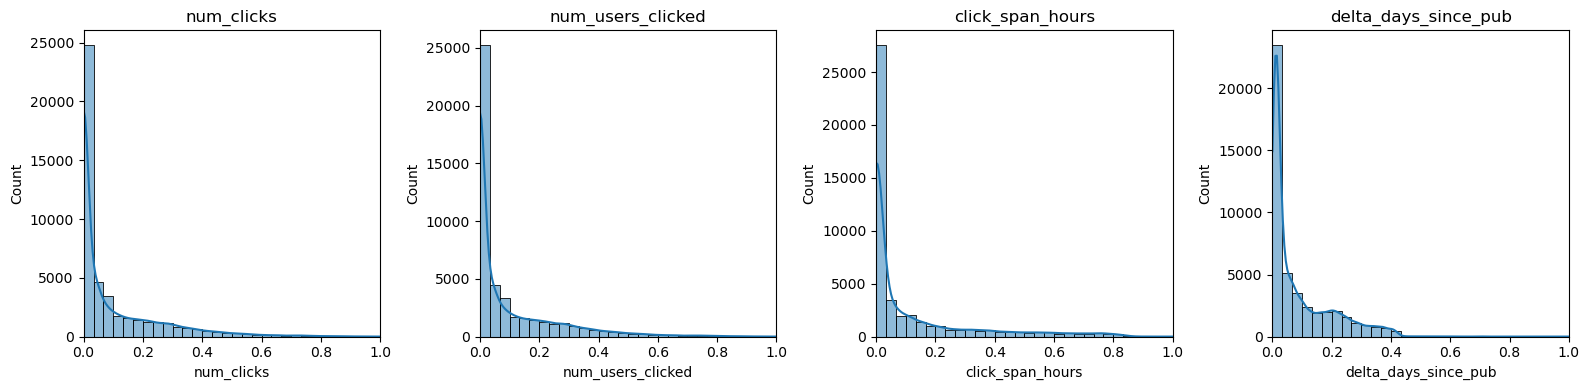

In [51]:
# Vérification de la variance
plot_feature_distributions(
    article_clicks_features,
    feature_columns=["num_clicks", "num_users_clicked", "click_span_hours", "delta_days_since_pub"]
)


#### 📌 3: Embeddings

In [52]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Charger les embeddings (index = article_id)
embeddings_df = pd.read_parquet("./data/articles_embeddings_pca.parquet")
embeddings_df.index.name = "article_id"

# 2. Garder uniquement les articles cliqués
embeddings_filtered = embeddings_df.loc[embeddings_df.index.intersection(clicked_article_ids)]

# 3. Vérifier les valeurs (min/max) pour décider de la normalisation
print("Min:", embeddings_filtered.min().min(), "Max:", embeddings_filtered.max().max())

# 4. Normalisation si nécessaire (par colonne)
scaler = MinMaxScaler()
embeddings_normalized = pd.DataFrame(
    scaler.fit_transform(embeddings_filtered),
    index=embeddings_filtered.index,
    columns=embeddings_filtered.columns
)

embeddings_normalized

Min: -22.667787551879883 Max: 20.652034759521484


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
article_id,,,,,,,,,,,,,,,,,,,,,
3,0.338502,0.781313,0.178670,0.645552,0.648202,0.396773,0.482124,0.288584,0.586785,0.775073,...,0.513373,0.415849,0.450855,0.637513,0.664632,0.339570,0.322270,0.401168,0.527650,0.328401
27,0.233939,0.453415,0.279923,0.677090,0.581332,0.603472,0.402781,0.304126,0.437974,0.827413,...,0.460132,0.333359,0.546271,0.407001,0.573745,0.235091,0.513336,0.519278,0.426018,0.527091
69,0.306419,0.715136,0.358801,0.445108,0.593920,0.379970,0.422582,0.380719,0.354350,0.631077,...,0.326871,0.261393,0.493929,0.689789,0.552606,0.310475,0.612973,0.567309,0.369407,0.332710
81,0.251242,0.688924,0.260744,0.637864,0.592283,0.472482,0.416699,0.398406,0.357115,0.709954,...,0.420788,0.339843,0.543833,0.558554,0.500629,0.389851,0.467755,0.644168,0.478085,0.427997
84,0.112736,0.646962,0.368792,0.498718,0.581802,0.405507,0.327446,0.330366,0.415830,0.676578,...,0.297965,0.358423,0.511341,0.630716,0.454144,0.432006,0.347233,0.473326,0.358407,0.361635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364017,0.604784,0.611850,0.377301,0.661967,0.392525,0.683066,0.389788,0.501751,0.367658,0.536619,...,0.556957,0.371015,0.547664,0.463625,0.690320,0.542784,0.598484,0.464618,0.424030,0.506296
364022,0.419011,0.792951,0.370740,0.545155,0.616214,0.758736,0.307420,0.366321,0.415869,0.536285,...,0.373224,0.503626,0.465564,0.272404,0.460719,0.429600,0.552849,0.407583,0.338115,0.288294
364028,0.543778,0.833372,0.263209,0.504064,0.429761,0.361478,0.476600,0.467516,0.536725,0.453019,...,0.639735,0.526516,0.474469,0.555761,0.294170,0.595951,0.565906,0.438273,0.554021,0.364353


### Assemblage du dataframe des features article

In [53]:
articles_merged = words_count_normalized.merge(
    article_clicks_features, on="article_id"
).merge(
    embeddings_normalized, left_on="article_id", right_index=True
)

In [54]:
articles_merged

,article_id,words_count,num_clicks,num_users_clicked,click_span_hours,delta_days_since_pub,0,1,2,3,...,31,32,33,34,35,36,37,38,39,40
0,3,0.617858,0.000000,0.000000,0.000000,0.297006,0.338502,0.781313,0.178670,0.645552,...,0.513373,0.415849,0.450855,0.637513,0.664632,0.339570,0.322270,0.401168,0.527650,0.328401
1,27,0.570343,0.000000,0.000000,0.000000,0.092576,0.233939,0.453415,0.279923,0.677090,...,0.460132,0.333359,0.546271,0.407001,0.573745,0.235091,0.513336,0.519278,0.426018,0.527091
2,69,0.644072,0.000000,0.000000,0.000000,0.413080,0.306419,0.715136,0.358801,0.445108,...,0.326871,0.261393,0.493929,0.689789,0.552606,0.310475,0.612973,0.567309,0.369407,0.332710
3,81,0.603190,0.041242,0.041606,0.012364,0.403983,0.251242,0.688924,0.260744,0.637864,...,0.420788,0.339843,0.543833,0.558554,0.500629,0.389851,0.467755,0.644168,0.478085,0.427997
4,84,0.575455,0.000000,0.000000,0.000000,0.403508,0.112736,0.646962,0.368792,0.498718,...,0.297965,0.358423,0.511341,0.630716,0.454144,0.432006,0.347233,0.473326,0.358407,0.361635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46028,364017,0.611802,0.248426,0.241284,0.779026,0.063214,0.604784,0.611850,0.377301,0.661967,...,0.556957,0.371015,0.547664,0.463625,0.690320,0.542784,0.598484,0.464618,0.424030,0.506296
46029,364022,0.648285,0.000000,0.000000,0.000000,0.597569,0.419011,0.792951,0.370740,0.545155,...,0.373224,0.503626,0.465564,0.272404,0.460719,0.429600,0.552849,0.407583,0.338115,0.288294
46030,364028,0.641707,0.000000,0.000000,0.000000,0.408264,0.543778,0.833372,0.263209,0.504064,...,0.639735,0.526516,0.474469,0.555761,0.294170,0.595951,0.565906,0.438273,0.554021,0.364353
46031,364043,0.697039,0.152989,0.154339,0.589568,0.222374,0.403265,0.582130,0.628788,0.591323,...,0.541219,0.512922,0.559284,0.512749,0.375271,0.402815,0.615266,0.427236,0.562657,0.399384


In [55]:
# Vérification rapide :
print("Dimensions après fusion :", articles_merged.shape)
print("Nombre de NaN dans embeddings :")
print(articles_merged.iloc[:, -embeddings_df.shape[1]:].isna().sum().sum())  # colonne embeddings uniquement

Dimensions après fusion : (46033, 47)
Nombre de NaN dans embeddings :
0


### Re-ordonnancement des articles pour correspondre aux idx (de la matrice user-item)

In [56]:
# 1. Ajouter item_idx à merged_df
articles_merged["item_idx"] = articles_merged["article_id"].map(item_mapping)

# 2. Supprimer les articles qui n'existent pas dans le mapping (juste par sécurité)
articles_merged = articles_merged.dropna(subset=["item_idx"])
articles_merged["item_idx"] = articles_merged["item_idx"].astype(int)

# 3. Réordonner par item_idx
articles_merged = articles_merged.sort_values("item_idx")

### Construction de la matrice sparse

🚧 LightFM ne connait que les articles de la matrice d'interaction, donc tous les non-cliqués sont absents.

In [57]:
# 4. Construire la matrice CSR finale
item_features_matrix = csr_matrix(articles_merged.drop(columns=["article_id", "item_idx"]).values)

# 5. Vérification
print("✅ Matrice finale :", item_features_matrix.shape)

✅ Matrice finale : (46033, 46)


### Entrainement et évaluation du modèle hybride avec user features + items features

### Vérification de la matrice d'interactions

In [58]:
print("user_features_matrix shape:", user_features_matrix.shape)
print("item_features_matrix shape:", item_features_matrix.shape if 'item_features_matrix' in locals() else "Not defined")


user_features_matrix shape: (322897, 24)
item_features_matrix shape: (46033, 46)


In [59]:
print("train_matrix shape:", train_matrix_hybrid.shape)
print("Nombre total d'interactions :", train_matrix_hybrid.nnz)
print("Valeurs uniques dans train_matrix :", np.unique(train_matrix_hybrid.data))


train_matrix shape: (322897, 46033)
Nombre total d'interactions : 31932
Valeurs uniques dans train_matrix : [0.1431114  0.18453512 0.18946382 0.20836785 0.23784459 0.24465054
 0.25192964 0.2695773  0.29248124 0.31546488 0.32365668 0.32389054
 0.36907023 0.38776192 0.41702187 0.43067655 0.44250706 0.4608454
 0.5        0.51335436 0.5532948  0.564575   0.5693234  0.5849625
 0.60170126 0.60920453 0.63092977 0.6437928  0.6477811  0.6609641
 0.6826062  0.70281816 0.7124144  0.73042274 0.73141587 0.7324868
 0.7520505  0.7564708  0.7729429  0.7758643  0.79248124 0.813196
 0.83291125 0.83404374 0.87695146 0.88562185 0.90367746 0.9216908
 0.961916   0.96739626 0.9786022  1.        ]


### Vérification des matrices user et item features

In [60]:
print("User features - min/max:", user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:", item_features_matrix.min(), item_features_matrix.max())


User features - min/max: 0.0 1.0000000000000002
Item features - min/max: 0.0 1.0000001192092896


In [61]:
import numpy as np

print("User features - min/max:",
      user_features_matrix.min(), user_features_matrix.max())
print("Item features - min/max:",
      item_features_matrix.min(), item_features_matrix.max())

# Convert to dense for mean/std
user_dense = user_features_matrix.toarray()
item_dense = item_features_matrix.toarray()

print("User features - mean/std:",
      np.mean(user_dense), np.std(user_dense))
print("Item features - mean/std:",
      np.mean(item_dense), np.std(item_dense))


User features - min/max: 0.0 1.0000000000000002
Item features - min/max: 0.0 1.0000001192092896
User features - mean/std: 0.18283405276186812 0.37095055517201053
Item features - mean/std: 0.4642401458376035 0.1776323995043909


In [62]:
print(user_features_matrix[:5].toarray())
print(item_features_matrix[:5].toarray())


[[0.19728975 0.18253639 0.18757316 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         1.         0.         0.
  1.         0.         0.         0.         0.         1.        ]
 [0.26973676 0.24363452 0.25035718 0.         1.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         1.
  0.         0.         0.         0.         0.         1.        ]
 [0.08730211 0.08487459 0.08721655 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         1.
  0.         0.         0.         0.         0.         1.        ]
 [0.26973676 0.29770403 0.30591864 0.         0.         0.
  0.         1.         0.         0.         0.         0.
  0.         0.         0.         0.         1.         0.
  1.         0.         0.         0.         0.         1.        ]
 [0.

In [63]:
best_model, best_params, best_score = grid_search_lightfm(
    train_matrix_hybrid,
    test_matrix_hybrid,
    user_features=user_features_matrix,
    item_features=item_features_matrix,
    k=5,
    max_epochs=30,
    eval_metric="ndcg",
    eval_every=5,
    patience=3
)

🔍 Recherche sur 12 combinaisons...

🚀 Entraînement modèle : loss=warp, components=32, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.1521
📉 Epoch 10 — ndcg@5 = 0.1506
📉 Epoch 15 — ndcg@5 = 0.1506
📉 Epoch 20 — ndcg@5 = 0.1506
🛑 Early stopping à l’epoch 20 (aucune amélioration depuis 3 évaluations)

🚀 Entraînement modèle : loss=warp, components=32, lr=0.05
📉 Epoch 5 — ndcg@5 = 0.1452
📉 Epoch 10 — ndcg@5 = 0.1332
📉 Epoch 15 — ndcg@5 = 0.1475
📉 Epoch 20 — ndcg@5 = 0.1420
📉 Epoch 25 — ndcg@5 = 0.1521
📉 Epoch 30 — ndcg@5 = 0.1514

🚀 Entraînement modèle : loss=warp, components=32, lr=0.1
📉 Epoch 5 — ndcg@5 = 0.1459
📉 Epoch 10 — ndcg@5 = 0.1421
📉 Epoch 15 — ndcg@5 = 0.1379
📉 Epoch 20 — ndcg@5 = 0.1367
🛑 Early stopping à l’epoch 20 (aucune amélioration depuis 3 évaluations)

🚀 Entraînement modèle : loss=warp, components=64, lr=0.01
📉 Epoch 5 — ndcg@5 = 0.1506
📉 Epoch 10 — ndcg@5 = 0.1488
📉 Epoch 15 — ndcg@5 = 0.1487
📉 Epoch 20 — ndcg@5 = 0.1504
🛑 Early stopping à l’epoch 20 (aucune amélioration depuis 3 évalua

In [64]:
model_hybrid_user_item = train_lightfm_model(train_matrix_hybrid, best_params,
                                        user_features=user_features_matrix,
                                        item_features=item_features_matrix,
                                        epochs=50, num_threads=8
                                       )

Entraînement LightFM:   0%|          | 0/50 [00:00<?, ?it/s]

In [65]:
results = evaluate_lightfm_model(model_hybrid_user_item, train_matrix_hybrid, test_matrix_hybrid,
                                 user_features=user_features_matrix, item_features=item_features_matrix,
                                 experiment_name="user-item + user features + item features")
print(results)

Shape passée à ndcg_at_k: (322897, 46033)


Calcul NDCG@k (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

Calcul RMSE/MAE (parallèle):   0%|          | 0/322897 [00:00<?, ?it/s]

📄 Résultats mis à jour dans results/experiments_lightfm.csv
{'Experiment': 'user-item + user features + item features', 'Hit@5': 0.004931193, 'Recall@5': 0.024655963302752295, 'NDCG@5': 0.015330806630939043, 'RMSE': 781.4430066709282, 'MAE': 770.5544696072919}


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiments_results(results_file="results/experiments_lightfm.csv"):
    """
    Charge le fichier CSV des résultats LightFM, 
    et trace un barplot comparatif des principales métriques.
    """

    # 1. Charger le CSV
    results_df = pd.read_csv(results_file)
    print(f"✅ Chargé : {results_df.shape[0]} expériences.")

    # 2. Afficher le DataFrame brut
    print(results_df)

    # 3. Choisir les métriques à tracer
    metrics_to_plot = ['Hit@5', 'Recall@5', 'NDCG@5']

    # 4. Tracer un barplot par métrique
    for metric in metrics_to_plot:
        plt.figure(figsize=(8, 5))
        plt.barh(results_df['Experiment'], results_df[metric], color='skyblue')
        plt.xlabel(metric)
        plt.title(f'Comparaison des expériences - {metric}')
        plt.grid(True, axis='x')
        plt.show()

    return results_df


✅ Chargé : 8 expériences.
                                  Experiment     Hit@5  Recall@5    NDCG@5  \
0                                  user-item  0.036429  0.182145  0.129126   
1                           user-minmax_item  0.008486  0.042431  0.032088   
2                  user-item + user features  0.001261  0.006307  0.003406   
3  user-item + user features + item features  0.005390  0.026950  0.021767   
4                                  user-item  0.036471  0.182355  0.129338   
5                           user-minmax_item  0.008372  0.041858  0.031408   
6                  user-item + user features  0.000688  0.003440  0.001812   
7  user-item + user features + item features  0.004931  0.024656  0.015331   

         RMSE         MAE  
0    2.469346    1.931845  
1    2.013459    1.553353  
2  323.790686  318.816688  
3  396.710702  391.265317  
4    2.470857    1.932961  
5    2.017821    1.553814  
6  605.719343  596.212290  
7  781.443007  770.554470  


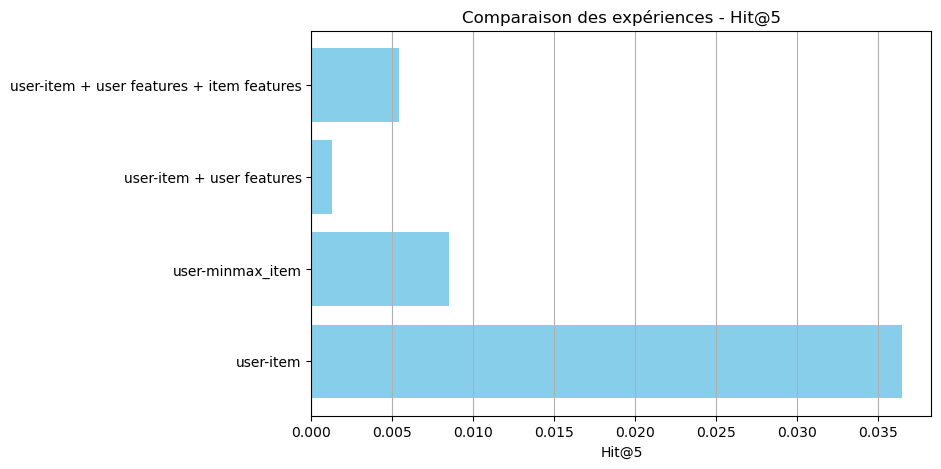

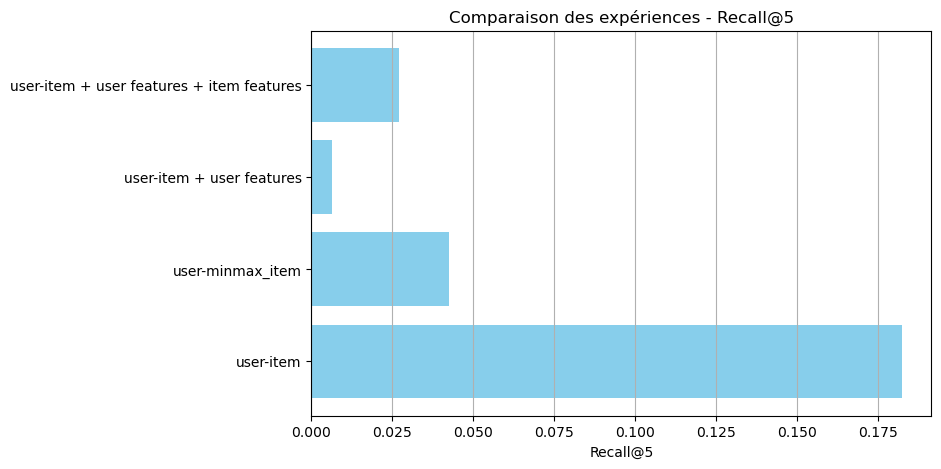

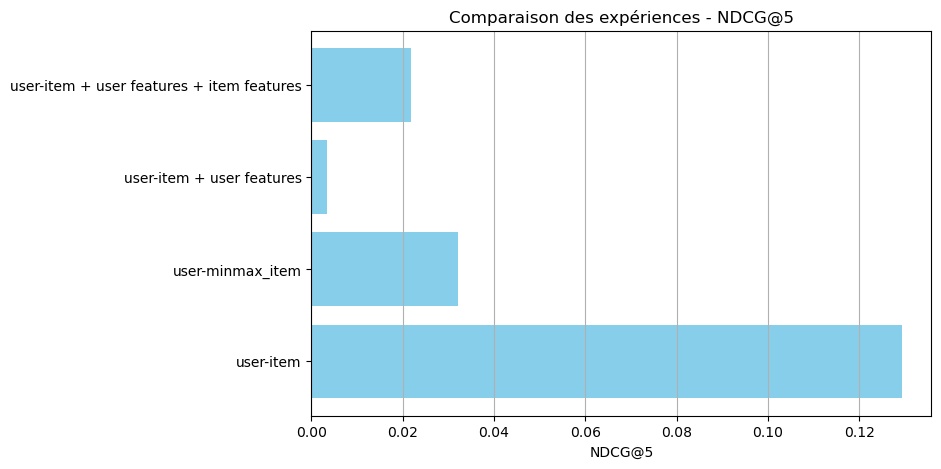

In [67]:
results_df = plot_experiments_results()